This project realized the core parts of DeepAR structure, with the tricks
* (✅implemented) id, timestamp, category and other side info as covariates to feed into the model as input
* (✅implemented) Data Scale Normalizing (count data divided by mean, covariates normalized)
* (✅implemented) Weighted Sampling in Training
* Data Augment & Training Instance Sampling

In [20]:
# Read data and aggregate into monthly sale_cnt

import pandas as pd

train_df = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv')
# columns: date, date_block_num, shop_id, item_id, item_price, item_cnt_day
train_monthly_df = train_df.groupby(['date_block_num','shop_id','item_id']).agg(item_cnt_month=('item_cnt_day','sum')).reset_index()
train_monthly_df['shop_item'] = train_monthly_df['shop_id'].astype('string') + '-' + train_monthly_df['item_id'].astype('string')

shop_item_list = pd.unique(train_monthly_df['shop_item'])
print("cnt of shop_item:",len(shop_item_list))
print('max shop id:', max(train_monthly_df.shop_id))
print('max item id:', max(train_monthly_df.item_id))
train_monthly_df

cnt of shop_item: 424124
max shop id: 59
max item id: 22169


,date_block_num,shop_id,item_id,item_cnt_month,shop_item
0,0,0,32,6.0,0-32
1,0,0,33,3.0,0-33
2,0,0,35,1.0,0-35
3,0,0,43,1.0,0-43
4,0,0,51,2.0,0-51
...,...,...,...,...,...
1609119,33,59,22087,6.0,59-22087
1609120,33,59,22088,2.0,59-22088
1609121,33,59,22091,1.0,59-22091
1609122,33,59,22100,1.0,59-22100


In [21]:
# get the sequence of each shop_item

import numpy as np

data_seq_dict = {}
for shop_item in shop_item_list:
    shop_id = float(shop_item.split('-')[0])
    item_id = float(shop_item.split('-')[1])
    data_seq_dict[shop_item] = [[0.0, shop_id, item_id, float(i%12)] for i in range(0,34)]
for _, row in train_monthly_df.iterrows():
    data_seq_dict[row['shop_item']][int(row['date_block_num'])][0] = row['item_cnt_month']

data_seq_array = np.array(list(data_seq_dict.values()))
print(data_seq_array.shape)  # (424124, 34, 4)
print(data_seq_array)

(424124, 34, 4)
[[[6.0000e+00 0.0000e+00 3.2000e+01 0.0000e+00]
  [1.0000e+01 0.0000e+00 3.2000e+01 1.0000e+00]
  [0.0000e+00 0.0000e+00 3.2000e+01 2.0000e+00]
  ...
  [0.0000e+00 0.0000e+00 3.2000e+01 7.0000e+00]
  [0.0000e+00 0.0000e+00 3.2000e+01 8.0000e+00]
  [0.0000e+00 0.0000e+00 3.2000e+01 9.0000e+00]]

 [[3.0000e+00 0.0000e+00 3.3000e+01 0.0000e+00]
  [3.0000e+00 0.0000e+00 3.3000e+01 1.0000e+00]
  [0.0000e+00 0.0000e+00 3.3000e+01 2.0000e+00]
  ...
  [0.0000e+00 0.0000e+00 3.3000e+01 7.0000e+00]
  [0.0000e+00 0.0000e+00 3.3000e+01 8.0000e+00]
  [0.0000e+00 0.0000e+00 3.3000e+01 9.0000e+00]]

 [[1.0000e+00 0.0000e+00 3.5000e+01 0.0000e+00]
  [1.4000e+01 0.0000e+00 3.5000e+01 1.0000e+00]
  [0.0000e+00 0.0000e+00 3.5000e+01 2.0000e+00]
  ...
  [0.0000e+00 0.0000e+00 3.5000e+01 7.0000e+00]
  [0.0000e+00 0.0000e+00 3.5000e+01 8.0000e+00]
  [0.0000e+00 0.0000e+00 3.5000e+01 9.0000e+00]]

 ...

 [[0.0000e+00 5.9000e+01 2.1361e+04 0.0000e+00]
  [0.0000e+00 5.9000e+01 2.1361e+04 1.0000

In [22]:
# get the default sequence for items: calculate the average sale_cnt as default sequence for items

item_seq_dict = {}
item_seq_num_dict = {}
for k, v in data_seq_dict.items():
    item = k.split('-')[1]
    if item not in item_seq_dict.keys():
        item_seq_dict[item] = v
        item_seq_num_dict[item] = 1
    else:
        item_seq_dict[item] = [[a+b for a, b in zip(i, j)] for i, j in zip(item_seq_dict[item], v)]
        item_seq_num_dict[item] += 1
for item in item_seq_dict.keys():
    item_seq_dict[item] = [[e / item_seq_num_dict[item] for e in step] for step in item_seq_dict[item]]

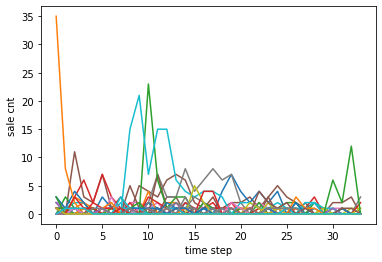

In [23]:
# plot curve

import matplotlib.pyplot as plt

row_random_array = np.arange(data_seq_array.shape[0])
np.random.shuffle(row_random_array)
row_random = data_seq_array[row_random_array][0:100,:,0]
for seq in row_random:
    plt.plot(seq)
plt.xlabel('time step')
plt.ylabel('sale cnt')
plt.show()

In [24]:
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K

# Normalize
data_seq_norm_array = data_seq_array  # (424124, 34, 4)
# normalize count data
data_seq_mean_array = data_seq_array[:,:,0].mean(axis=1)  # (424124,)
data_seq_mean_array = np.where(data_seq_mean_array==0.,K.epsilon(),data_seq_mean_array)
data_seq_norm_array[:,:,0] = data_seq_norm_array[:,:,0]/data_seq_mean_array[:,np.newaxis]
# normalize month
month_mean = np.mean([i for i in range(0,12)])
month_var = np.var([i for i in range(0,12)])
data_seq_norm_array[:,:,3] = (data_seq_norm_array[:,:,3] - month_mean)/month_var

# Split X and Y
X = data_seq_norm_array[:,0:-1,:]
Y = data_seq_norm_array[:,1:,:]
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.3)
sample_weights = X_train[:,:,0].mean(axis=1)+1

# # Normalize
# # X_train Normalize
# X_train_mean = X_train.mean(axis=1)  # (296886, 1)
# X_train_var = X_train.var(axis=1)  # (296886, 1)
# X_train = (X_train-X_train_mean.reshape((X_train_mean.shape[0],1,1)))/(X_train_var.reshape((X_train_mean.shape[0],1,1))+K.epsilon())  # (296886, 33, 1)
# # Normalize Y_train
# Y_train_mean = Y_train.mean(axis=1)
# Y_train_var = Y_train.var(axis=1)
# Y_train = (Y_train-Y_train_mean.reshape((Y_train_mean.shape[0],1,1)))/(Y_train_var.reshape((Y_train_mean.shape[0],1,1))+K.epsilon())  # (296886, 33, 1)
# # Normalize X_val
# X_val_mean = X_val.mean(axis=1)
# X_val_var = X_val.var(axis=1)
# X_val = (X_val-X_val_mean.reshape((X_val_mean.shape[0],1,1)))/(X_val_var.reshape((X_val_mean.shape[0],1,1))+K.epsilon())  # (127238, 33, 1)
# # Normalize Y_val
# Y_val_mean = Y_val.mean(axis=1)
# Y_val_var = Y_val.var(axis=1)
# Y_val = (Y_val-Y_val_mean.reshape((Y_val_mean.shape[0],1,1)))/(Y_val_var.reshape((Y_val_mean.shape[0],1,1))+K.epsilon())  # (127238, 33, 1)

In [65]:
# DeepAR

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

from math import log
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense, LSTM, Lambda, Concatenate, Reshape, Embedding, Conv1D
from tensorflow.keras.optimizers import Adam

def rmse(y_pred, y_true):
    mean = tf.slice(y_pred, [0,0,0], [-1,-1,1])
    gt = tf.slice(y_true, [0,0,0], [-1,-1,1])
    return tf.sqrt(tf.reduce_mean((gt - mean)**2))

def gaussian_likelihood(y_pred, y_true):
    mean = tf.slice(y_pred, [0,0,0], [-1,-1,1])
    stddev = tf.slice(y_pred, [0,0,1], [-1,-1,1]) + K.epsilon()
    gt = tf.slice(y_true, [0,0,0], [-1,-1,1])
    return -tf.reduce_sum(tfp.distributions.Normal(loc=mean, scale=stddev).log_prob(gt))

def negbin_likelihood(y_pred, y_true):
    mean = tf.slice(y_pred, [0,0,0], [-1,-1,1])
    alpha = tf.slice(y_pred, [0,0,1], [-1,-1,1])
    gt = tf.slice(y_true, [0,0,0], [-1,-1,1])
    return -tf.reduce_sum(tfp.distributions.NegativeBinomial(total_count=1/alpha, probs=1/(1+tf.multiply(mean,alpha))).log_prob(gt))

# model
# encoder+decoder (LSTM)
input_vec = Input(name='input', shape = (X.shape[1], X.shape[2]))
seq_vec = Lambda(lambda x: tf.slice(x, [0,0,0], [-1,-1,1]), name='seq_vec')(input_vec)
shop_vec = Lambda(lambda x: tf.reshape(tf.slice(x, [0,0,1], [-1,-1,1]),(-1, x.shape[1])), name='shop_seq_vec')(input_vec)
shop_emb_vec = Embedding(100, 4, name='shop_emb_seq_vec')(shop_vec)
item_vec = Lambda(lambda x: tf.reshape(tf.slice(x, [0,0,2], [-1,-1,1]),(-1, x.shape[1])), name='item_seq_vec')(input_vec)
item_emb_vec = Embedding(23000, 8, name='item_emb_seq_vec')(item_vec)
month_vec = Lambda(lambda x: tf.slice(x, [0,0,3], [-1,-1,1]), name='month_seq_vec')(input_vec)
lstm_input_vec = Concatenate(axis=2)([seq_vec, shop_emb_vec, item_emb_vec, month_vec])
lstm_vec = LSTM(8, return_sequences=True, name='encoder_decoder_1')(lstm_input_vec)  # (None, 33, 4)
lstm_vec = LSTM(4, return_sequences=True, name='encoder_decoder_2')(lstm_vec)  # (None, 33, 1)
# likelihood distribution
# Gaussian
mean_vec = Conv1D(filters=1, kernel_size=1)(lstm_vec)
theta_vec = Conv1D(filters=1, kernel_size=1, activation='softplus')(lstm_vec)
# Negative binomial
# mean_vec = Conv1D(filters=1, kernel_size=1, activation='softplus')(lstm_vec)
# theta_vec = Conv1D(filters=1, kernel_size=1, activation='softplus')(lstm_vec)
output_vec = Concatenate(axis=2)([mean_vec, theta_vec])

model = Model(inputs=[input_vec], outputs=[output_vec])
model.compile(loss=gaussian_likelihood, optimizer=Adam(learning_rate=0.025))
model.summary()

early_stopping=tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                min_delta=0.,
                                                patience=4, 
                                                verbose=0, 
                                                mode='auto',
                                                baseline=None, 
                                                restore_best_weights=True)
history = model.fit(x=X_train, 
                    y=Y_train, 
                    sample_weight=sample_weights, 
                    validation_data=(X_val, Y_val), 
                    epochs=100, 
                    batch_size=1024*1024,
                    callbacks = [early_stopping])

Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 33, 4)]      0                                            
__________________________________________________________________________________________________
shop_seq_vec (Lambda)           (None, 33)           0           input[0][0]                      
__________________________________________________________________________________________________
item_seq_vec (Lambda)           (None, 33)           0           input[0][0]                      
__________________________________________________________________________________________________
seq_vec (Lambda)                (None, 33, 1)        0           input[0][0]                      
___________________________________________________________________________________________

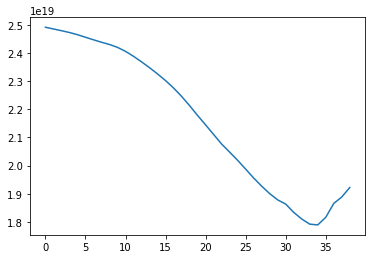

In [66]:
plt.plot(history.history['val_loss'])
plt.show()

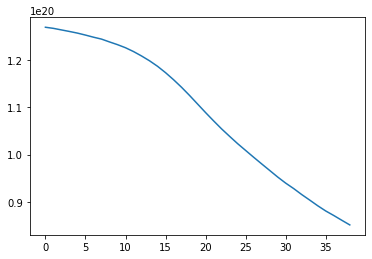

In [67]:
plt.plot(history.history['loss'])
plt.show()

In [68]:
# Prepare Test dataset

test_df = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/test.csv').set_index('ID')
test_df['shop_item'] = test_df['shop_id'].astype('string') + '-' + test_df['item_id'].astype('string')

X_test = []
for _, row in test_df.iterrows():
    shop_item = row['shop_item']
    shop_id = row['shop_id']
    item_id = row['item_id']
    if shop_item in data_seq_dict.keys():
        seq = np.array(data_seq_dict[shop_item])[:,0]
    elif row['item_id'] in item_seq_dict.keys():
        seq = np.array(item_seq_dict[item_id])[:,0]
        print('No shop-item', item_id, 'observed in training samples.')
    else:
        seq = np.array([0.0 for i in range(0,34)])
    shop_id_seq = np.array([float(shop_id) for i in range(len(seq))])
    item_id_seq = np.array([float(item_id) for i in range(len(seq))])
    month_seq = np.array([float(i%12) for i in range(len(seq))])
    X_test.append(np.stack([seq,shop_id_seq,item_id_seq,month_seq], axis=1))
X_test = np.stack(X_test, axis=0)
X_test = X_test[:,1:,:]

In [70]:
# Normalize X_test
X_test_norm = X_test
# normalize count data
X_test_mean = X_test[:,:,0].mean(axis=1)
X_test_mean = np.where(X_test_mean==0.,K.epsilon(),X_test_mean)
X_test_norm[:,:,0] = X_test_norm[:,:,0]/X_test_mean[:,np.newaxis]
# normalize month
month_mean = np.mean([i for i in range(0,12)])
month_var = np.var([i for i in range(0,12)])
X_test_norm[:,:,3] = (X_test_norm[:,:,3] - month_mean)/month_var

In [71]:
pred = model.predict(X_test_norm)

pred = pred[:,-1:,0]
pred = pred.reshape((pred.shape[0]))

In [72]:
# recover the prediction (de-normalized)
X_test_mean = np.where(X_test_mean==K.epsilon(),0.,X_test_mean)
pred = pred * X_test_mean
pred[pred<0] = 0.0
pred

array([0.11470533, 0.        , 0.12997359, ..., 0.02615443, 0.        ,
       0.127454  ])

In [73]:
submission_df = pd.DataFrame(pred, columns=['item_cnt_month'])
submission_df.index.name = 'ID'
submission_df

,item_cnt_month
ID,
0,0.114705
1,0.000000
2,0.129974
3,0.011028
4,0.000000
...,...
214195,0.620848
214196,0.000000
214197,0.026154


In [74]:
submission_df.to_csv('/kaggle/working/submission.csv')